## ResNet-18 With Deformable Convolutions

We enhanced traditional convolutions by introducing deformable convolutions, which allow adaptive offsets in the sampling locations, enabling the receptive field to adjust dynamically rather than following a fixed grid. This approach learns spatial offsets at each position, helping the network better capture local features with complex shapes, rotations, and deformations—particularly valuable for the Flowers102 dataset, where flowers vary widely in scale and orientation. In ResNet-18, we integrated deformable convolutions by replacing standard layers within the residual blocks and trained the model with both transfer learning and non-transfer learning to evaluate its effectiveness in capturing fine-grained features 

### Importing libraries

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### Initializing data pipelines, training pipelines, transformations, and visualisations

The following are codes for transforming and visualising data, initialising datasets and dataloaders, and defining the training and validation functions. The code follows the same structure and logic as the initialisation code used in the main task.

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# load the dataset
train_set = Flowers102(root='data/flowers102', split='train', transform=transform, download=True)
val_set = Flowers102(root='data/flowers102', split='val', transform=transform, download=True)
test_set = Flowers102(root='data/flowers102', split='test', transform=transform, download=True)

In [11]:
# create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# early stopper
class EarlyStopper:
    def __init__(self, patience=5, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf') 
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, val_loss, model):
        if val_loss < self.best_score:
            self.best_score = val_loss 
            self.counter = 0 
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [ ]:
# freezing stages in the ResNet-18 model for transfer learning
def set_model_frozen_stages(model, num_frozen_stages):
    # freeze the beginning layers
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.relu.parameters():
        param.requires_grad = False
    for param in model.maxpool.parameters():
        param.requires_grad = False
    layers_to_freeze = [f'layer{i}' for i in range(1, num_frozen_stages+1, 1)]
    for name, child in model.named_children():
        # freeze the specified number of stages
        for i, (name, child) in enumerate(model.named_children()):
            if name in layers_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100):
    train_losses_history = []
    val_losses_history = []
    train_accuracies_history = []
    val_accuracies_history = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        

        average_train_loss = running_loss / total
        average_train_accuracy = correct / total
        train_losses_history.append(average_train_loss)
        train_accuracies_history.append(average_train_accuracy)

        
       # Validation
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        running_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                

        average_val_loss = running_loss / total
        average_val_accuracy = correct / total
        val_losses_history.append(average_val_loss)
        val_accuracies_history.append(average_val_accuracy)

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")

        if earlystopper.early_stop(average_val_loss, model):
            break 
    
    return train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history

In [ ]:
def plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(train_losses_history, label='Training Loss', color='blue')
    ax1.plot(val_losses_history, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies_history, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies_history, label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout() 
    plt.show()

### Implementing deformable convolution layer

The idea behind deformable convolutions is to learn the spatial offsets for each convolution operation, allowing the kernel to "move" to focus on more relevant parts of the image, as opposed to using a fixed grid of pixels.

To implement this, we utilise the Pytorch DeformConv2d module. Inside it, we further define an offset convolutional module, offset_conv. The offset_conv module generates two sets of offsets (horizontal and vertical), one for each spatial location in the input. The DeformConv2d module then takes in the offset_conv outputs and uses them to determine the sampling locations in the image.

In [6]:
from torchvision.ops import DeformConv2d

class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.deformconv2d = DeformConv2d(in_channels, out_channels, kernel_size, stride, padding)
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=padding, 
                                     bias=True)
    
    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        x = self.deformconv2d(x, offset)
        
        return x

### Training ResNet-18 model with deformable convolutions in the starting stage

We modify ResNet-18 by replacing all its regular convolutions in the model's first stage with deformable convolution layers. This allows the network to learn adaptive receptive fields from the beginning, improving its ability to handle complex transformations in input data.

In [ ]:
# deform start
model_deform_start = models.resnet18(pretrained=True)
model_deform_start.fc = nn.Linear(model_deform_start.fc.in_features, 102)
model_deform_start.conv1 = DeformableConv2d(model_deform_start.conv1.in_channels, model_deform_start.conv1.out_channels, model_deform_start.conv1.kernel_size[0], model_deform_start.conv1.stride, model_deform_start.conv1.padding)
print(model_deform_start)

ResNet(
  (conv1): DeformableConv2d(
    (deformconv2d): DeformConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (offset_conv): Conv2d(3, 98, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform_start.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet_deformconv_start.pth')
train_losses_history_deform_start, train_accuracies_history_deform_start, val_losses_history_deform_start, val_accuracies_history_deform_start = train_model(model_deform_start, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

Epoch [0/100], Train Loss: 0.1388, Train Accuracy: 0.0912, Validation Loss: 0.1224, Validation Accuracy: 0.1069
Epoch [1/100], Train Loss: 0.0950, Train Accuracy: 0.2441, Validation Loss: 0.0989, Validation Accuracy: 0.2490
Epoch [2/100], Train Loss: 0.0696, Train Accuracy: 0.4275, Validation Loss: 0.0861, Validation Accuracy: 0.3029
Epoch [3/100], Train Loss: 0.0450, Train Accuracy: 0.6392, Validation Loss: 0.0773, Validation Accuracy: 0.3725
Epoch [4/100], Train Loss: 0.0244, Train Accuracy: 0.8363, Validation Loss: 0.0714, Validation Accuracy: 0.4265
Epoch [5/100], Train Loss: 0.0132, Train Accuracy: 0.9245, Validation Loss: 0.0672, Validation Accuracy: 0.4451
Epoch [6/100], Train Loss: 0.0067, Train Accuracy: 0.9725, Validation Loss: 0.0637, Validation Accuracy: 0.4775
Epoch [7/100], Train Loss: 0.0028, Train Accuracy: 0.9922, Validation Loss: 0.0544, Validation Accuracy: 0.5480
Epoch [8/100], Train Loss: 0.0011, Train Accuracy: 1.0000, Validation Loss: 0.0521, Validation Accuracy:

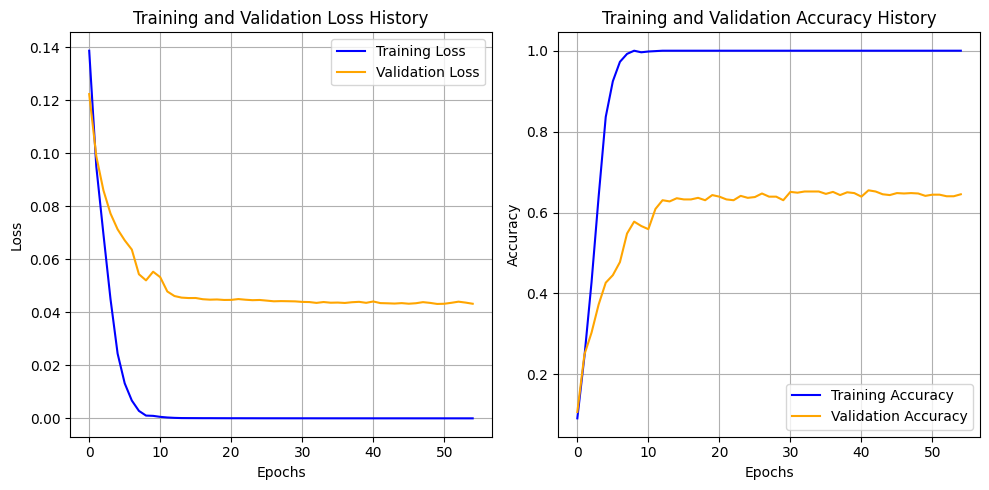

In [ ]:

plot_loss_and_accuracy(train_losses_history_deform_start, train_accuracies_history_deform_start, val_losses_history_deform_start, val_accuracies_history_deform_start)

### Training ResNet-18 model with deformable convolutions in the last stage with pretraining

We modify ResNet-18 by replacing all its regular convolutions in the model's last stage with deformable convolution layers, while freezing all 3 previous stages, finetuning only this last stage and the fully-connected layer. The hypothesis is that this modification will improve the model's ability to learn spatially adaptive features in the later layers, while allowing the model to benefit from pretrained data in its earlier layers.

In [19]:
model_deform_end_pretrained = models.resnet18(pretrained=True)
model_deform_end_pretrained.fc = nn.Linear(model_deform_end_pretrained.fc.in_features, 102)
set_model_frozen_stages(model_deform_end_pretrained, 3)

In [20]:
model_deform_end_pretrained.layer4.conv1 = DeformableConv2d(model_deform_end_pretrained.layer4[1].conv1.in_channels, model_deform_end_pretrained.layer4[0].conv1.out_channels, model_deform_end_pretrained.layer4[0].conv1.kernel_size[0], model_deform_end_pretrained.layer4[0].conv1.stride, model_deform_end_pretrained.layer4[0].conv1.padding)
model_deform_end_pretrained.layer4.conv2 = DeformableConv2d(model_deform_end_pretrained.layer4[1].conv2.in_channels, model_deform_end_pretrained.layer4[0].conv2.out_channels, model_deform_end_pretrained.layer4[0].conv2.kernel_size[0], model_deform_end_pretrained.layer4[0].conv2.stride, model_deform_end_pretrained.layer4[0].conv2.padding)
model_deform_end_pretrained.layer4.conv1 = DeformableConv2d(model_deform_end_pretrained.layer4[1].conv1.in_channels, model_deform_end_pretrained.layer4[1].conv1.out_channels, model_deform_end_pretrained.layer4[1].conv1.kernel_size[0], model_deform_end_pretrained.layer4[1].conv1.stride, model_deform_end_pretrained.layer4[1].conv1.padding)
model_deform_end_pretrained.layer4.conv2 = DeformableConv2d(model_deform_end_pretrained.layer4[1].conv2.in_channels, model_deform_end_pretrained.layer4[1].conv2.out_channels, model_deform_end_pretrained.layer4[1].conv2.kernel_size[0], model_deform_end_pretrained.layer4[1].conv2.stride, model_deform_end_pretrained.layer4[1].conv2.padding)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform_end_pretrained.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet_deformconv_end_pretrained.pth')

In [22]:
train_losses_history_deform_end_pretrained, train_accuracies_history_deform_end_pretrained, val_losses_history_deform_end_pretrained, val_accuracies_history_deform_end_pretrained = train_model(model_deform_end_pretrained, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

Epoch [0/100], Train Loss: 0.1526, Train Accuracy: 0.0069, Validation Loss: 0.1471, Validation Accuracy: 0.0137
Epoch [1/100], Train Loss: 0.1456, Train Accuracy: 0.0216, Validation Loss: 0.1430, Validation Accuracy: 0.0382
Epoch [2/100], Train Loss: 0.1369, Train Accuracy: 0.0333, Validation Loss: 0.1305, Validation Accuracy: 0.0549
Epoch [3/100], Train Loss: 0.1229, Train Accuracy: 0.0824, Validation Loss: 0.1155, Validation Accuracy: 0.1059
Epoch [4/100], Train Loss: 0.1084, Train Accuracy: 0.1206, Validation Loss: 0.0987, Validation Accuracy: 0.1804
Epoch [5/100], Train Loss: 0.0834, Train Accuracy: 0.2529, Validation Loss: 0.0908, Validation Accuracy: 0.2451
Epoch [6/100], Train Loss: 0.0671, Train Accuracy: 0.3814, Validation Loss: 0.0711, Validation Accuracy: 0.4000
Epoch [7/100], Train Loss: 0.0430, Train Accuracy: 0.5784, Validation Loss: 0.0651, Validation Accuracy: 0.4667
Epoch [8/100], Train Loss: 0.0296, Train Accuracy: 0.7069, Validation Loss: 0.0652, Validation Accuracy:

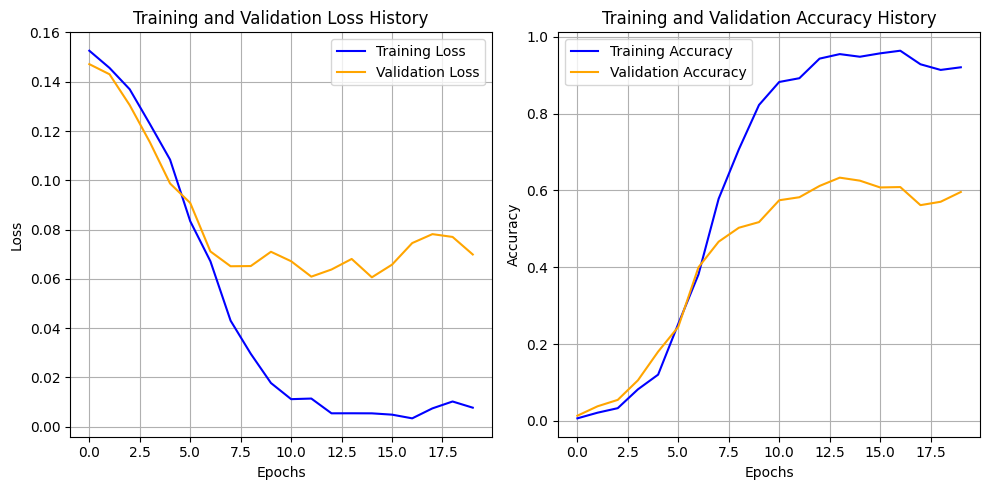

In [ ]:
plot_loss_and_accuracy(train_losses_history_deform_end_pretrained, train_accuracies_history_deform_end_pretrained, val_losses_history_deform_end_pretrained, val_accuracies_history_deform_end_pretrained )

### Training ResNet-18 model with deformable convolutions in the last stage without pretraining

We now modify ResNet-18 by replacing all its regular convolutions in the model's last stage with deformable convolution layers, but keep all previous layers unfrozen to train from scratch on the dataset. This allows us to fully adapt the network, including the deformable convolution layers, to the specific task and dataset.

In [24]:
model_deform_end_fromscratch = models.resnet18(pretrained=True)
model_deform_end_fromscratch.fc = nn.Linear(model_deform_end_fromscratch.fc.in_features, 102)
model_deform_end_fromscratch.layer4.conv1 = DeformableConv2d(model_deform_end_fromscratch.layer4[1].conv1.in_channels, model_deform_end_fromscratch.layer4[0].conv1.out_channels, model_deform_end_fromscratch.layer4[0].conv1.kernel_size[0], model_deform_end_fromscratch.layer4[0].conv1.stride, model_deform_end_fromscratch.layer4[0].conv1.padding)
model_deform_end_fromscratch.layer4.conv2 = DeformableConv2d(model_deform_end_fromscratch.layer4[1].conv2.in_channels, model_deform_end_fromscratch.layer4[0].conv2.out_channels, model_deform_end_fromscratch.layer4[0].conv2.kernel_size[0], model_deform_end_fromscratch.layer4[0].conv2.stride, model_deform_end_fromscratch.layer4[0].conv2.padding)
model_deform_end_fromscratch.layer4.conv1 = DeformableConv2d(model_deform_end_fromscratch.layer4[1].conv1.in_channels, model_deform_end_fromscratch.layer4[1].conv1.out_channels, model_deform_end_fromscratch.layer4[1].conv1.kernel_size[0], model_deform_end_fromscratch.layer4[1].conv1.stride, model_deform_end_fromscratch.layer4[1].conv1.padding)
model_deform_end_fromscratch.layer4.conv2 = DeformableConv2d(model_deform_end_fromscratch.layer4[1].conv2.in_channels, model_deform_end_fromscratch.layer4[1].conv2.out_channels, model_deform_end_fromscratch.layer4[1].conv2.kernel_size[0], model_deform_end_fromscratch.layer4[1].conv2.stride, model_deform_end_fromscratch.layer4[1].conv2.padding)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform_end_fromscratch.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet_deformconv_end_fromscratch.pth')

In [33]:
train_losses_history_deform_end_fromscratch, train_accuracies_history_deform_end_fromscratch, val_losses_history_deform_end_fromscratch, val_accuracies_history_deform_end_fromscratch = train_model(model_deform_end_fromscratch, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

Epoch [0/100], Train Loss: 0.1623, Train Accuracy: 0.0167, Validation Loss: 0.1453, Validation Accuracy: 0.0245
Epoch [1/100], Train Loss: 0.1416, Train Accuracy: 0.0216, Validation Loss: 0.1409, Validation Accuracy: 0.0343
Epoch [2/100], Train Loss: 0.1378, Train Accuracy: 0.0245, Validation Loss: 0.1417, Validation Accuracy: 0.0304
Epoch [3/100], Train Loss: 0.1466, Train Accuracy: 0.0206, Validation Loss: 0.1395, Validation Accuracy: 0.0275
Epoch [4/100], Train Loss: 0.1406, Train Accuracy: 0.0284, Validation Loss: 0.1382, Validation Accuracy: 0.0333
Epoch [5/100], Train Loss: 0.1322, Train Accuracy: 0.0324, Validation Loss: 0.1325, Validation Accuracy: 0.0431
Epoch [6/100], Train Loss: 0.1282, Train Accuracy: 0.0461, Validation Loss: 0.1286, Validation Accuracy: 0.0500
Epoch [7/100], Train Loss: 0.1365, Train Accuracy: 0.0471, Validation Loss: 0.2246, Validation Accuracy: 0.0294
Epoch [8/100], Train Loss: 0.1892, Train Accuracy: 0.0245, Validation Loss: 0.4047, Validation Accuracy:

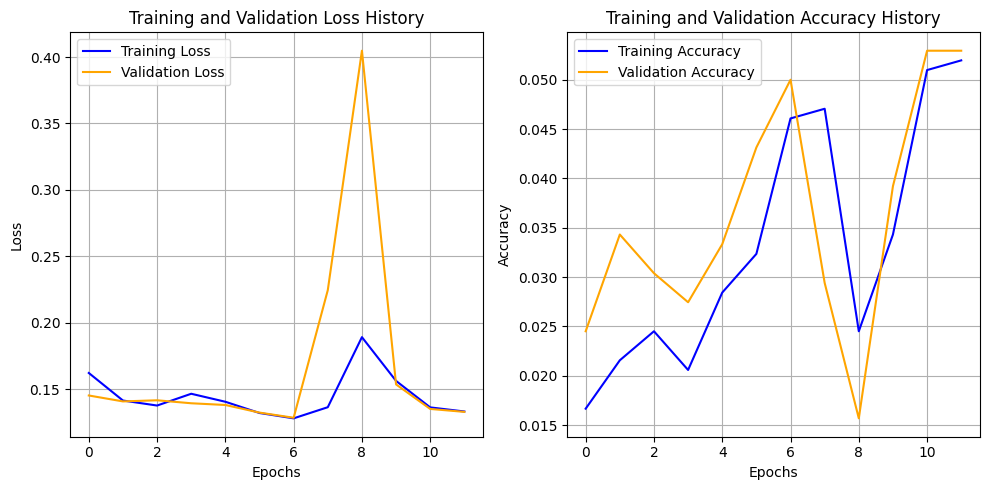

In [64]:
plot_loss_and_accuracy(train_losses_history_deform_end_fromscratch, train_accuracies_history_deform_end_fromscratch, val_losses_history_deform_end_fromscratch, val_accuracies_history_deform_end_fromscratch )

### Training ResNet-18 model with deformable convolutions in the middle stage with pretraining

We modify ResNet-18 by replacing all its regular convolutions in the model's middle stage (stage 3) with deformable convolution layers, while freezing its 2 previous stages, finetuning only this 3rd stage and the fully-connected layer. The hypothesis is that this modification will improve the model's ability to learn spatially adaptive features in the middle layers, allow the model to benefit from pretrained data in its earlier layers, while also leaving more layers for further finetuning and adapting on the training dataset.

In [57]:
model_deform_middle_pretrained = models.resnet18(pretrained=True)
model_deform_middle_pretrained.fc = nn.Linear(model_deform_middle_pretrained.fc.in_features, 102)
set_model_frozen_stages(model_deform_middle_pretrained, 2)

In [58]:
model_deform_middle_pretrained.layer3.conv1 = DeformableConv2d(model_deform_middle_pretrained.layer3[1].conv1.in_channels, model_deform_middle_pretrained.layer3[0].conv1.out_channels, model_deform_middle_pretrained.layer3[0].conv1.kernel_size[0], model_deform_middle_pretrained.layer3[0].conv1.stride, model_deform_middle_pretrained.layer3[0].conv1.padding)
model_deform_middle_pretrained.layer3.conv2 = DeformableConv2d(model_deform_middle_pretrained.layer3[1].conv2.in_channels, model_deform_middle_pretrained.layer3[0].conv2.out_channels, model_deform_middle_pretrained.layer3[0].conv2.kernel_size[0], model_deform_middle_pretrained.layer3[0].conv2.stride, model_deform_middle_pretrained.layer3[0].conv2.padding)
model_deform_middle_pretrained.layer3.conv1 = DeformableConv2d(model_deform_middle_pretrained.layer3[1].conv1.in_channels, model_deform_middle_pretrained.layer3[1].conv1.out_channels, model_deform_middle_pretrained.layer3[1].conv1.kernel_size[0], model_deform_middle_pretrained.layer3[1].conv1.stride, model_deform_middle_pretrained.layer3[1].conv1.padding)
model_deform_middle_pretrained.layer3.conv2 = DeformableConv2d(model_deform_middle_pretrained.layer3[1].conv2.in_channels, model_deform_middle_pretrained.layer3[1].conv2.out_channels, model_deform_middle_pretrained.layer3[1].conv2.kernel_size[0], model_deform_middle_pretrained.layer3[1].conv2.stride, model_deform_middle_pretrained.layer3[1].conv2.padding)

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform_middle_pretrained.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet_deformconv_middle_pretrained.pth')
train_losses_history_deform_middle_pretrained, train_accuracies_history_deform_middle_pretrained, val_losses_history_deform_middle_pretrained, val_accuracies_history_deform_middle_pretrained = train_model(model_deform_middle_pretrained, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

Epoch [0/100], Train Loss: 0.1338, Train Accuracy: 0.0882, Validation Loss: 0.1653, Validation Accuracy: 0.1343
Epoch [1/100], Train Loss: 0.0802, Train Accuracy: 0.3461, Validation Loss: 0.0883, Validation Accuracy: 0.3127
Epoch [2/100], Train Loss: 0.0507, Train Accuracy: 0.5569, Validation Loss: 0.0918, Validation Accuracy: 0.3637
Epoch [3/100], Train Loss: 0.0371, Train Accuracy: 0.6745, Validation Loss: 0.0567, Validation Accuracy: 0.5392
Epoch [4/100], Train Loss: 0.0251, Train Accuracy: 0.7784, Validation Loss: 0.0604, Validation Accuracy: 0.5216
Epoch [5/100], Train Loss: 0.0177, Train Accuracy: 0.8578, Validation Loss: 0.0471, Validation Accuracy: 0.5912
Epoch [6/100], Train Loss: 0.0145, Train Accuracy: 0.8667, Validation Loss: 0.0601, Validation Accuracy: 0.5353
Epoch [7/100], Train Loss: 0.0121, Train Accuracy: 0.8892, Validation Loss: 0.0534, Validation Accuracy: 0.5745
Epoch [8/100], Train Loss: 0.0088, Train Accuracy: 0.9216, Validation Loss: 0.0581, Validation Accuracy:

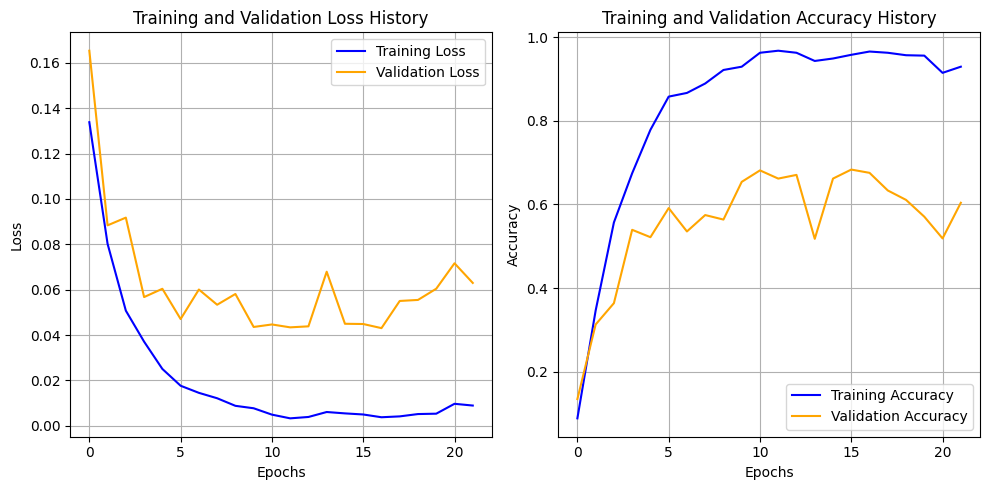

In [65]:
plot_loss_and_accuracy(train_losses_history_deform_middle_pretrained, train_accuracies_history_deform_middle_pretrained, val_losses_history_deform_middle_pretrained, val_accuracies_history_deform_middle_pretrained )

### Training ResNet-18 model with deformable convolutions in the middle stage without pretraining

We modify ResNet-18 by replacing all its regular convolutions in the model's middle stage (stage 3) with deformable convolution layers, but keep all previous layers unfrozen to train from scratch on the dataset. This allows us to fully adapt the network, including the deformable convolution layers, to the specific task and dataset. This is to find out whether positioning the deformable convolutional layer in the centre of the model architecture will allow the network to adaptively modify its receptive fields in the middle stage, where the network already has learned relatively high-level, abstract features. By training the model from scratch, it can also learn the high-level features needed to best utilise the deformable convolution layer.

In [60]:
model_deform_middle_fromscratch = models.resnet18(pretrained=True)
model_deform_middle_fromscratch.fc = nn.Linear(model_deform_middle_fromscratch.fc.in_features, 102)
set_model_frozen_stages(model_deform_middle_fromscratch, 2)

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
model_deform_middle_fromscratch.layer3.conv1 = DeformableConv2d(model_deform_middle_fromscratch.layer3[1].conv1.in_channels, model_deform_middle_fromscratch.layer3[0].conv1.out_channels, model_deform_middle_fromscratch.layer3[0].conv1.kernel_size[0], model_deform_middle_fromscratch.layer3[0].conv1.stride, model_deform_middle_fromscratch.layer3[0].conv1.padding)
model_deform_middle_fromscratch.layer3.conv2 = DeformableConv2d(model_deform_middle_fromscratch.layer3[1].conv2.in_channels, model_deform_middle_fromscratch.layer3[0].conv2.out_channels, model_deform_middle_fromscratch.layer3[0].conv2.kernel_size[0], model_deform_middle_fromscratch.layer3[0].conv2.stride, model_deform_middle_fromscratch.layer3[0].conv2.padding)
model_deform_middle_fromscratch.layer3.conv1 = DeformableConv2d(model_deform_middle_fromscratch.layer3[1].conv1.in_channels, model_deform_middle_fromscratch.layer3[1].conv1.out_channels, model_deform_middle_fromscratch.layer3[1].conv1.kernel_size[0], model_deform_middle_fromscratch.layer3[1].conv1.stride, model_deform_middle_fromscratch.layer3[1].conv1.padding)
model_deform_middle_fromscratch.layer3.conv2 = DeformableConv2d(model_deform_middle_fromscratch.layer3[1].conv2.in_channels, model_deform_middle_fromscratch.layer3[1].conv2.out_channels, model_deform_middle_fromscratch.layer3[1].conv2.kernel_size[0], model_deform_middle_fromscratch.layer3[1].conv2.stride, model_deform_middle_fromscratch.layer3[1].conv2.padding)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform_middle_fromscratch.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet_deformconv_middle_fromscratch.pth')
train_losses_history_deform_middle_fromscratch, train_accuracies_history_deform_middle_fromscratch, val_losses_history_deform_middle_fromscratch, val_accuracies_history_deform_middle_fromscratch = train_model(model_deform_middle_fromscratch, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

Epoch [0/100], Train Loss: 0.1258, Train Accuracy: 0.1333, Validation Loss: 0.1292, Validation Accuracy: 0.1863
Epoch [1/100], Train Loss: 0.0730, Train Accuracy: 0.4000, Validation Loss: 0.0815, Validation Accuracy: 0.3461
Epoch [2/100], Train Loss: 0.0435, Train Accuracy: 0.6196, Validation Loss: 0.0652, Validation Accuracy: 0.4941
Epoch [3/100], Train Loss: 0.0289, Train Accuracy: 0.7343, Validation Loss: 0.0832, Validation Accuracy: 0.3775
Epoch [4/100], Train Loss: 0.0221, Train Accuracy: 0.7971, Validation Loss: 0.0501, Validation Accuracy: 0.6020
Epoch [5/100], Train Loss: 0.0160, Train Accuracy: 0.8657, Validation Loss: 0.0873, Validation Accuracy: 0.4049
Epoch [6/100], Train Loss: 0.0139, Train Accuracy: 0.8824, Validation Loss: 0.0756, Validation Accuracy: 0.4833
Epoch [7/100], Train Loss: 0.0091, Train Accuracy: 0.9235, Validation Loss: 0.0437, Validation Accuracy: 0.6520
Epoch [8/100], Train Loss: 0.0045, Train Accuracy: 0.9627, Validation Loss: 0.0398, Validation Accuracy:

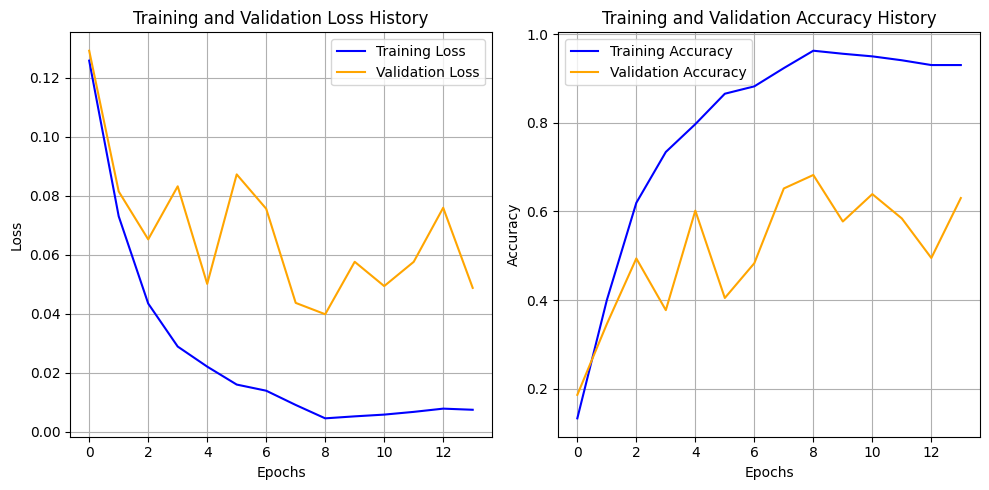

In [66]:
plot_loss_and_accuracy(train_losses_history_deform_middle_fromscratch, train_accuracies_history_deform_middle_fromscratch, val_losses_history_deform_middle_fromscratch, val_accuracies_history_deform_middle_fromscratch)

### Visualising histories for train and validation losses and accuracies 

We plot the histories for the train and validation loss and accuracies for all the models. From the graphs, it can be seen that the replacing the convolutional layers in the middle of ResNet-18 while using pretraining led to the best validation accuracy at 0.6833. This result highlights that positioning deformable convolutions in the middle stage of ResNet-18 might be more effective than placing them in the early or later stages. The middle stage is critical for capturing mid-level features (e.g., textures, shapes, part relationships), and deformable convolutions enhance this by allowing dynamic adjustment of receptive fields, allowing the model to capture important spatial relationships in the middle stages of the network, where object shapes and transformations become more complex, while benefiting from the pretrained weights that provided a strong initialization.

In contrast, placing the deformable convolutions at the end resulted in the lowest validation accuracies across pretrained and non-pretrained models, with the accuracy for the non-pretrained model with deformable convolutions at the end being drastically lower than the rest. This suggests that deformable convolutions placed at the end of the network may have been less effective at extracting important features, especially when the network is already learning higher-level representations in later layers. Thus, deformable convolutions are more suitable for being placed in earlier layers  where they can better capture low- and mid-level features such as edges, textures, and patterns, which are crucial for building a strong feature representation early in the network.

Additionally, the poorer performance of the non-pretrained model with deformable convolutions at the end suggests that the model struggled to learn relevant features without the aid of pretraining, which may have been exacerbated by the suboptimal placement of deformable convolutions. This suggests that fine-tuning with pretraining is required to achieve decent accuracy, especially when modifying the architecture with complex layers like deformable convolutions.

However, it can be seen that the validation accuracies achieved by these models are still lower than their counterparts with no deformable convolutions. Particularly, the best-performing model, pretrained ResNet-18 with deformable convolutions in the middle, achieved a test accuracy of , was still outperformed by the baseline ResNet-18 model trained from scratch which had a test accuracy of 81.54%. The results were surprising, as we initially hypothesized that deformable convolutions would improve the model’s performance by allowing it to better handle spatial variations in the flower images. Despite the adaptive nature of deformable convolutions, the results suggest that the added complexity of deformable convolutions might have hindered the model's ability to generalize effectively on the Flowers102 dataset, leading to overfitting. We hypothesize that, if pre-trained weights specifically for the deformable convolution layers are available, incorporating them into the model could significantly improve the learning process. This would allow the deformable convolutions to start with feature representations that have already been optimized on similar tasks or datasets. As a result, the model might be able to adapt more quickly and effectively, potentially improving both convergence speed and validation accuracy. Pre-trained deformable convolution weights could help the model learn important spatial and structural features in the data more efficiently, enhancing its ability to generalize from the start.


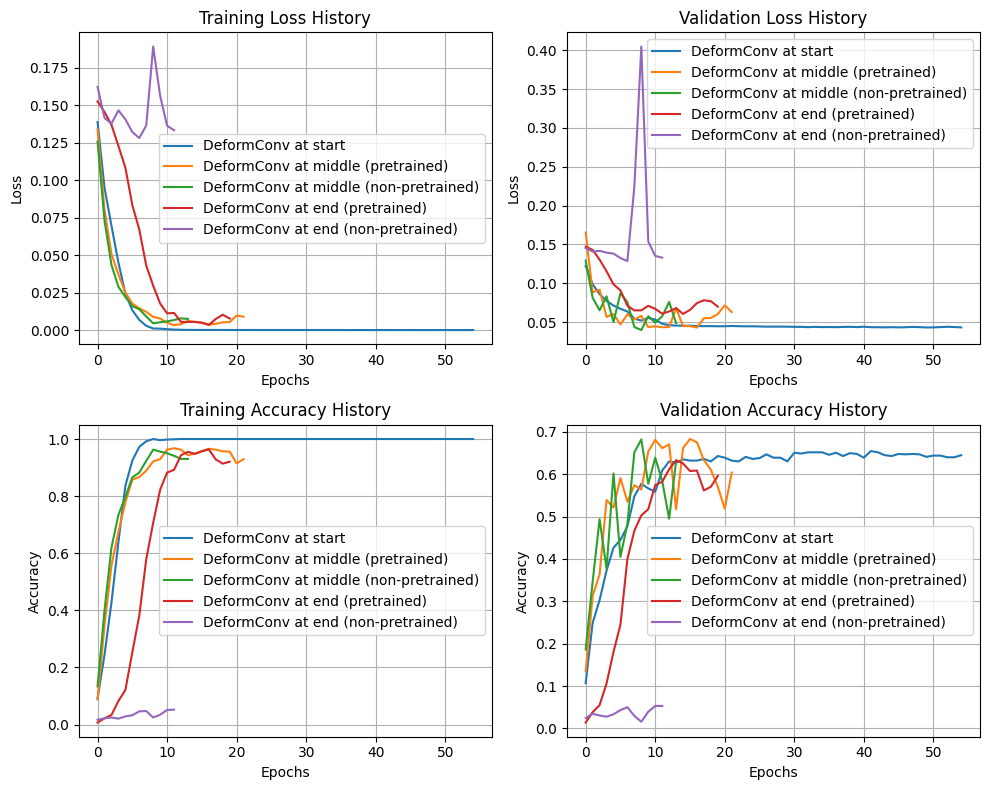

In [68]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
ax1.plot(train_losses_history_deform_start, label='DeformConv at start')
ax1.plot(train_losses_history_deform_middle_pretrained, label='DeformConv at middle (pretrained)')
ax1.plot(train_losses_history_deform_middle_fromscratch, label='DeformConv at middle (non-pretrained)')
ax1.plot(train_losses_history_deform_end_pretrained, label='DeformConv at end (pretrained)')
ax1.plot(train_losses_history_deform_end_fromscratch, label='DeformConv at end (non-pretrained)')
ax1.set_title('Training Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

ax2.plot(val_losses_history_deform_start, label='DeformConv at start')
ax2.plot(val_losses_history_deform_middle_pretrained, label='DeformConv at middle (pretrained)')
ax2.plot(val_losses_history_deform_middle_fromscratch, label='DeformConv at middle (non-pretrained)')
ax2.plot(val_losses_history_deform_end_pretrained, label='DeformConv at end (pretrained)')
ax2.plot(val_losses_history_deform_end_fromscratch, label='DeformConv at end (non-pretrained)')
ax2.set_title('Validation Loss History')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

ax3.plot(train_accuracies_history_deform_start, label='DeformConv at start')
ax3.plot(train_accuracies_history_deform_middle_pretrained, label='DeformConv at middle (pretrained)')
ax3.plot(train_accuracies_history_deform_middle_fromscratch, label='DeformConv at middle (non-pretrained)')
ax3.plot(train_accuracies_history_deform_end_pretrained, label='DeformConv at end (pretrained)')
ax3.plot(train_accuracies_history_deform_end_fromscratch, label='DeformConv at end (non-pretrained)')
ax3.set_title('Training Accuracy History')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid()

ax4.plot(val_accuracies_history_deform_start, label='DeformConv at start')
ax4.plot(val_accuracies_history_deform_middle_pretrained, label='DeformConv at middle (pretrained)')
ax4.plot(val_accuracies_history_deform_middle_fromscratch, label='DeformConv at middle (non-pretrained)')
ax4.plot(val_accuracies_history_deform_end_pretrained, label='DeformConv at end (pretrained)')
ax4.plot(val_accuracies_history_deform_end_fromscratch, label='DeformConv at end (non-pretrained)')
ax4.set_title('Validation Accuracy History')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid()
plt.tight_layout() 
plt.show()

{'Start': 0.6549019607843137, 'Middle (pretrained)': 0.6833333333333333, 'Middle (non-pretrained)': 0.6823529411764706, 'End (pretrained)': 0.6333333333333333, 'End (non-pretrained)': 0.052941176470588235}


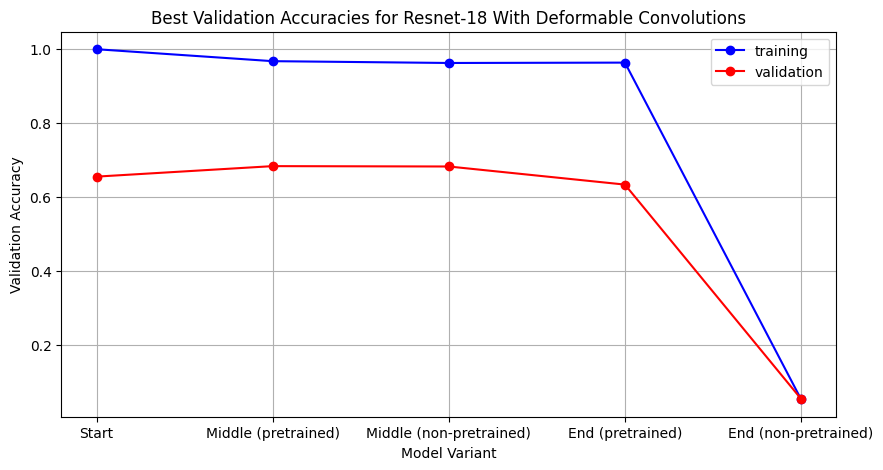

In [82]:
# Data for best validation accuracies
best_val_accuracies_deformconv = {}
best_val_accuracies_deformconv['Start'] = max(val_accuracies_history_deform_start)
best_val_accuracies_deformconv['Middle (pretrained)'] = max(val_accuracies_history_deform_middle_pretrained)
best_val_accuracies_deformconv['Middle (non-pretrained)'] = max(val_accuracies_history_deform_middle_fromscratch)
best_val_accuracies_deformconv['End (pretrained)'] = max(val_accuracies_history_deform_end_pretrained)
best_val_accuracies_deformconv['End (non-pretrained)'] = max(val_accuracies_history_deform_end_fromscratch)
print(best_val_accuracies_deformconv)

best_train_accuracies_deformconv = {}
best_train_accuracies_deformconv['Start'] = max(train_accuracies_history_deform_start)
best_train_accuracies_deformconv['Middle (pretrained)'] = max(train_accuracies_history_deform_middle_pretrained)
best_train_accuracies_deformconv['Middle (non-pretrained)'] = max(train_accuracies_history_deform_middle_fromscratch)
best_train_accuracies_deformconv['End (pretrained)'] = max(train_accuracies_history_deform_end_pretrained)
best_train_accuracies_deformconv['End (non-pretrained)'] = max(train_accuracies_history_deform_end_fromscratch)


hyperparams = list(best_val_accuracies_deformconv.keys())
train_accuracies = list(best_train_accuracies_deformconv.values())
val_accuracies = list(best_val_accuracies_deformconv.values())

plt.figure(figsize=(10, 5))
plt.plot(hyperparams, train_accuracies, marker='o', linestyle='-', color='b', label='training')
plt.plot(hyperparams, val_accuracies, marker='o', linestyle='-', color='r', label='validation')
plt.title('Best Validation Accuracies for Resnet-18 With Deformable Convolutions')
plt.xlabel('Model Variant')
plt.ylabel('Validation Accuracy')
plt.xticks(hyperparams)
plt.grid()

# Show the plot
plt.legend()
plt.show()
print()

In [12]:
model_path = 'resnet_deformconv_middle_pretrained.pth'
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
model.layer3.conv1 = DeformableConv2d(model.layer3[1].conv1.in_channels, model.layer3[0].conv1.out_channels, model.layer3[0].conv1.kernel_size[0], model.layer3[0].conv1.stride, model.layer3[0].conv1.padding)
model.layer3.conv2 = DeformableConv2d(model.layer3[1].conv2.in_channels, model.layer3[0].conv2.out_channels, model.layer3[0].conv2.kernel_size[0], model.layer3[0].conv2.stride, model.layer3[0].conv2.padding)
model.layer3.conv1 = DeformableConv2d(model.layer3[1].conv1.in_channels, model.layer3[1].conv1.out_channels, model.layer3[1].conv1.kernel_size[0], model.layer3[1].conv1.stride, model.layer3[1].conv1.padding)
model.layer3.conv2 = DeformableConv2d(model.layer3[1].conv2.in_channels, model.layer3[1].conv2.out_channels, model.layer3[1].conv2.kernel_size[0], model.layer3[1].conv2.stride, model.layer3[1].conv2.padding)
loss_fn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():  # Disable gradient calculation during inference
    test_loss = 0
    total = 0
    correct = 0
    for inputs, labels in test_loader:
        # forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)  # Compute loss

        # accumulate loss for reporting
        test_loss += loss.item()

        # calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# final evaluation metrics
accuracy = 100 * correct / total
average_loss = test_loss / len(test_loader)

print(f'Evaluating model {model_path} on test set')
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Loss: {average_loss:.4f}")
print()

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Sheryl\AppData\Local\Temp\ipykernel_8880\102594854.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

Evaluating model resnet_deformconv_middle_pretrained.pth on test set
Test Accuracy: 64.45%
Test Loss: 1.4546

